In this blog post, I will continue using the Seaborn "Car Crashes" dataset. Previously, we analyzed the states in this dataset by using the k-means clustering algorithm. In this blog post, we will continue with this analysis, but instead use the DBSCAN algorithm. DBSCAN will allow us to identify states which are outliers/anomalies. 

# Get and Examine the Data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.get_dataset_names()
crashes = sns.load_dataset('car_crashes')
crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
0,18.8,7.332,5.640,18.048,15.040,784.55,145.08,AL
1,18.1,7.421,4.525,16.290,17.014,1053.48,133.93,AK
2,18.6,6.510,5.208,15.624,17.856,899.47,110.35,AZ
3,22.4,4.032,5.824,21.056,21.280,827.34,142.39,AR
4,12.0,4.200,3.360,10.920,10.680,878.41,165.63,CA


In the clustering blog post, we already established that this dataset has no NaN values and that it is ok to jump directly into analytics/visualizations. 

Let's perform the same PCA steps that we did in the clustering blog post. 

In [2]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=2)

# Remove the abbreviation column, as it is not helpful in comparing data points. 
crashes_without_abbrev = crashes.set_index('abbrev')
crashes_without_abbrev.loc[:, crashes_without_abbrev.columns != 'abbrev']
crashes_without_abbrev

crashes2D = pca.fit_transform(crashes_without_abbrev)
crashes2D = pd.DataFrame(crashes2D, index=crashes_without_abbrev.index)
pca.explained_variance_ratio_

array([0.98671551, 0.01155058])

From the explained variance ratio, we can see that nearly all of the variance (~98.7%) in the dataset is explained by the first principal component 

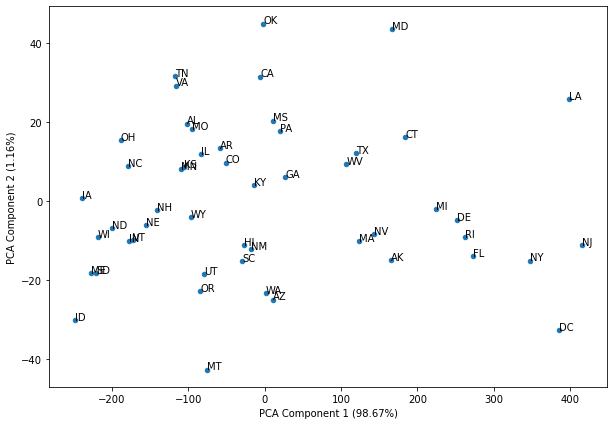

In [3]:
ax = crashes2D.plot.scatter(x=0, y=1, figsize=(10,7))
for ind,row in crashes2D.iterrows():
    ax.text(row[0], row[1], ind)
ax.set_xlabel('PCA Component 1 (98.67%)');
ax.set_ylabel('PCA Component 2 (1.16%)');

Above is a plot which can help us better visualize where states lie along the two principal component axes. 

First, let's look for potential outliers by computing the Z-scores on our dataframe. Any states with z-score values that are larger than 2 or smaller than -2 are potential outliers.

In [4]:
norm_crashes = (crashes_without_abbrev - crashes_without_abbrev.mean()) / crashes_without_abbrev.std()
norm_crashes.head() # As we can see, the data has been normalized. 

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
abbrev,,,,,,,
AL,0.730180,1.156638,0.435603,0.992425,0.274956,-0.574368,0.426272
AK,0.560360,1.200747,-0.209229,0.602537,0.799304,0.933964,-0.022674
AZ,0.681660,0.749253,0.185767,0.454831,1.022962,0.070177,-0.972106
AR,1.603542,-0.478849,0.542015,1.659539,1.932471,-0.334374,0.317961
CA,-0.919504,-0.395588,-0.882977,-0.588421,-0.883180,-0.047941,1.253703


In [5]:
cols = norm_crashes.columns.values.tolist()

norm_outliers = set()

for ind,row in norm_crashes.iterrows():
    for j in range(len(cols)):
        if(abs(row[cols[j]]) > 2):
            norm_outliers.add(ind)
norm_outliers

{'DC', 'HI', 'ID', 'LA', 'MD', 'MS', 'MT', 'ND', 'NJ', 'PA', 'SC', 'WV'}

We get the following list of states that are potential outliers. As we can see from the PCA plot, some of these states/districts, like DC, LA, and MT, lie on the outskirts of the plot and aren't close to other states.  

However, picking an arbitrary z-score threshold to detect outliers is a somewhat crude method. Let's now use the DBSCAN algorithm to identify outliers. 

## DBSCAN Algorithm

Now, we are ready to use the DBScan algorithm to identify the outlier states. This algorithm takes in two parameters: eps and min_samples. This algorithm finds core points and then expands outwards from those core points to form clusters.

In [42]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=26, min_samples=2)
dbscan.fit(crashes_without_abbrev)

DBSCAN(eps=26, min_samples=2)

In [51]:
dbscan.labels_

array([ 0,  1,  2,  3,  4,  3, -1,  5, -1,  5,  4,  2,  6,  0,  7,  6,  0,
        2, -1,  6, -1,  1, -1,  0,  4,  0, -1,  7,  1,  7, -1,  2, -1,  7,
        6,  7,  4,  0,  4,  5,  2,  6,  0,  8,  0,  7,  0,  2,  8,  6,  0])

We had to make our eps quite large and the min. samples small in order to get meaningful clusters. Otherwise, there were just too many outliers. 

Let's now plot these cluster assignments on our original PCA plot. 

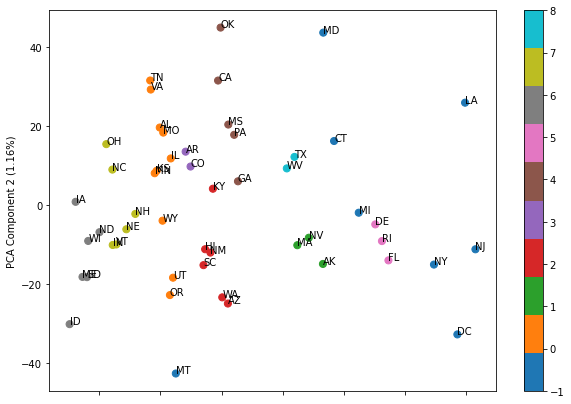

In [44]:
ax = crashes2D.plot.scatter(x=0, y=1, figsize=(10,7), c=dbscan.labels_, cmap='tab10', s=50)
for ind,row in crashes2D.iterrows():
    ax.text(row[0], row[1], ind)
ax.set_xlabel('PCA Component 1 (98.67%)');
ax.set_ylabel('PCA Component 2 (1.16%)');
# ax.axvline(x=85, color='r')

Let's try to get a list of the outliers identified by the DBSCAN algorithm. 

In [56]:
outliers = [crashes2D.index[i] for i in range(len(dbscan.labels_)) if dbscan.labels_[i] == -1]
outliers

['CT', 'DC', 'LA', 'MD', 'MI', 'MT', 'NJ', 'NY']

The DBSCAN algorithm, with eps of 26 and min_samples of 2, identifies the 8 states/districts above as outliers ('CT', 'DC', 'LA', etc.). 

It seems that from the plot, some states, like MT, LA, and MD, are so far from the rest of the states that they are clear outliers. Additionally, even though states like 'MI' might appear close to the pink cluster, remember that the PCA plot is a 2-D representation of high-dimensional data. Therefore, 'MI' is actually probably much further away from the pink cluster in reality. 